In [239]:
import numpy as np
numpy.set_printoptions(threshold=numpy.nan)
import argparse
import imutils
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

Center of contour

In [309]:
def countourCenter(image, MIN_THRESH = 1):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)
    image_gray = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(image_gray.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    coor = [] 
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > MIN_THRESH:
            # compute the center of the contour
            M = cv2.moments(c)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            coor.append([cX,cY])
            # draw the contour and center of the shape on the image
            cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
            cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
            cv2.putText(image, "center", (cX - 20, cY - 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            
    return image, coor

Sharpen method

In [2]:
def sharpen(image,n): 
    kernel = np.array([[-1,-1,-1], [-1,n,-1], [-1,-1,-1]])
    im = cv2.filter2D(image, -1, kernel)
    return im

Canny Edge Detection

In [3]:
def EdgeDetection_canny(image_color, threshold_1 = 0, threshold_2 = 100): 
            
    image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
    canny = cv2.Canny(image_gray, threshold_1, threshold_2)
    
    return canny

Orb detection

In [225]:
def orb_detection(image_color): 
    
    def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
        for kp in keypoints:
            x, y = kp.pt
            cv2.circle(vis, (int(x), int(y)), 5, color)
        return vis
    
    image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
    # Create ORB object, we can specify the number of key points we desire
    orb = cv2.ORB_create()

    # Determine key points
    keypoints = orb.detect(image_gray, None)

    # Obtain the descriptors
    keypoints, descriptors = orb.compute(image_gray, keypoints)
    print("Number of keypoints Detected: ", len(keypoints))
    
    #put info about keypoints into an array 
    arr =  np.empty([len(keypoints),4], dtype = float) 
    count = 0 
    for keyPoint in keypoints:
        x = keyPoint.pt[0]
        y = keyPoint.pt[1]
        s = keyPoint.size/2
        arr[count] = [x + s, x - s, y + s, y - s]
        count += 1

    # Draw rich keypoints on input image
    image = draw_keypoints(image_color,keypoints)
    return image, arr

Sobel edge detection

In [229]:
def sobel(img): #combined vertical and horizontal 

    x = cv2.Sobel(img,cv2.CV_16S,1,0)
    y = cv2.Sobel(img,cv2.CV_16S,0,1)
    absX = cv2.convertScaleAbs(x)
    absY = cv2.convertScaleAbs(y)

    dst = cv2.addWeighted(absX,0.5,absY,0.5,0)

    return dst

def sobelVertical(img): #sobel in the vertical direction 
    x = cv2.Sobel(img,cv2.CV_16S,1,0)
    return cv2.convertScaleAbs(x)


Laplace edge detection

In [230]:
def LiveCamEdgeDetection_Laplace(image_color):

    image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(image_gray, cv2.CV_64F)
    
    return laplacian
    

Fast feature detection

In [235]:
def fast_detection(image_color):
    
    def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
        for kp in keypoints:
            x, y = kp.pt
            cv2.circle(vis, (int(x), int(y)), 5, color)
        return vis
    
    image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
    fast = cv2.FastFeatureDetector_create()

    keypoints = fast.detect(image_gray, None)

    print ("Number of keypoints Detected: ", len(keypoints))

    img = draw_keypoints(image_color, keypoints)
    return img

Goal: Output X and Y coordinate for each star

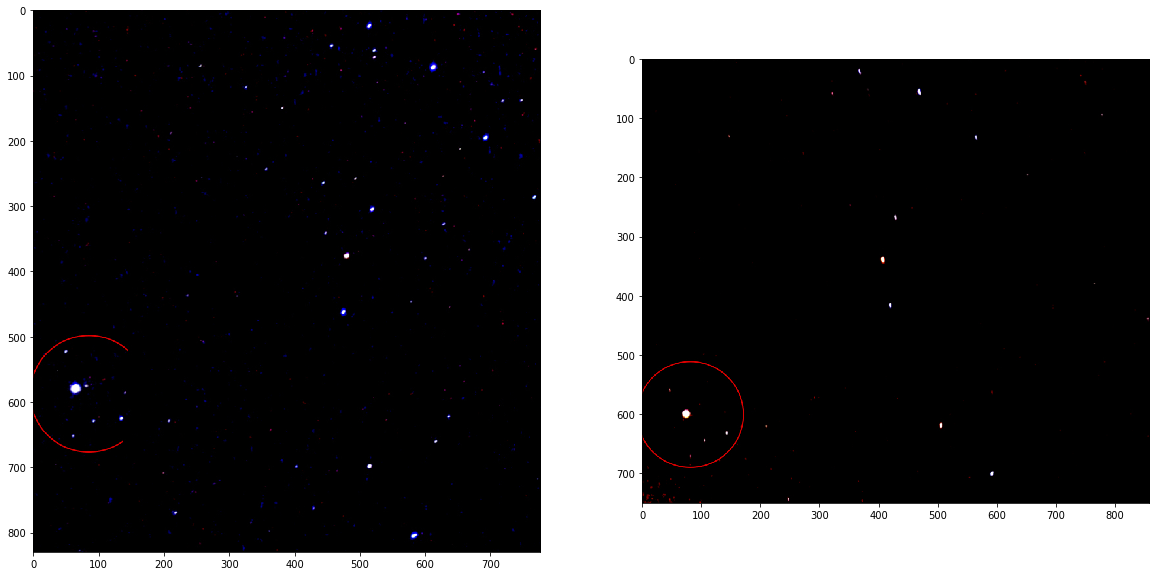

In [314]:
# load the image: 
pic1 = mpimg.imread('/Users/jeffhe/Desktop/commitments/bliss/Solar-sail-localization/picbase/Jupiter Picture1.jpg')
pic2 = mpimg.imread('/Users/jeffhe/Desktop/commitments/bliss/Solar-sail-localization/picbase/Jupiter Picture2.jpg')
plt.subplot(1,2,1), plt.imshow(pic1)
plt.subplot(1,2,2), plt.imshow(pic2)
pic1.setflags(write=1)
pic2.setflags(write=1)

(<matplotlib.axes._subplots.AxesSubplot at 0x12a191588>,
 <matplotlib.image.AxesImage at 0x1337a2710>)

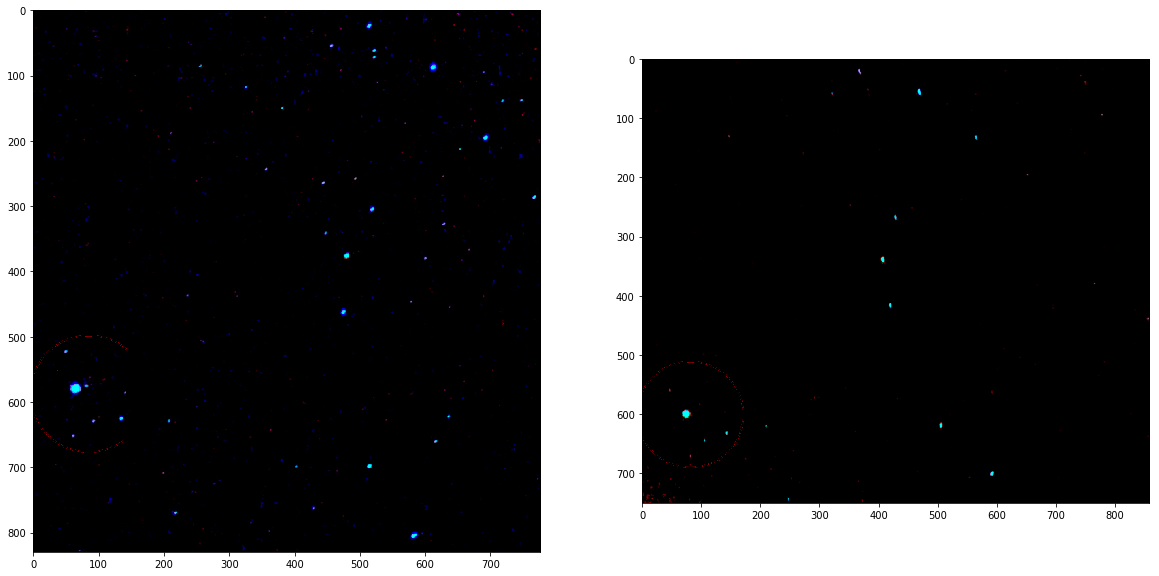

In [315]:
#eliminate the red part in both pictures 
for row in range(len(pic1)): 
    for col in range(len(pic1[row])): 
        if pic1[row,col,0] > 150: 
            pic1[row,col,0] = 0

for row in range(len(pic2)): 
    for col in range(len(pic2[row])): 
        if pic2[row,col,0] > 150: 
            pic2[row,col,0] = 0

plt.subplot(1,2,1), plt.imshow(pic1)
plt.subplot(1,2,2), plt.imshow(pic2)

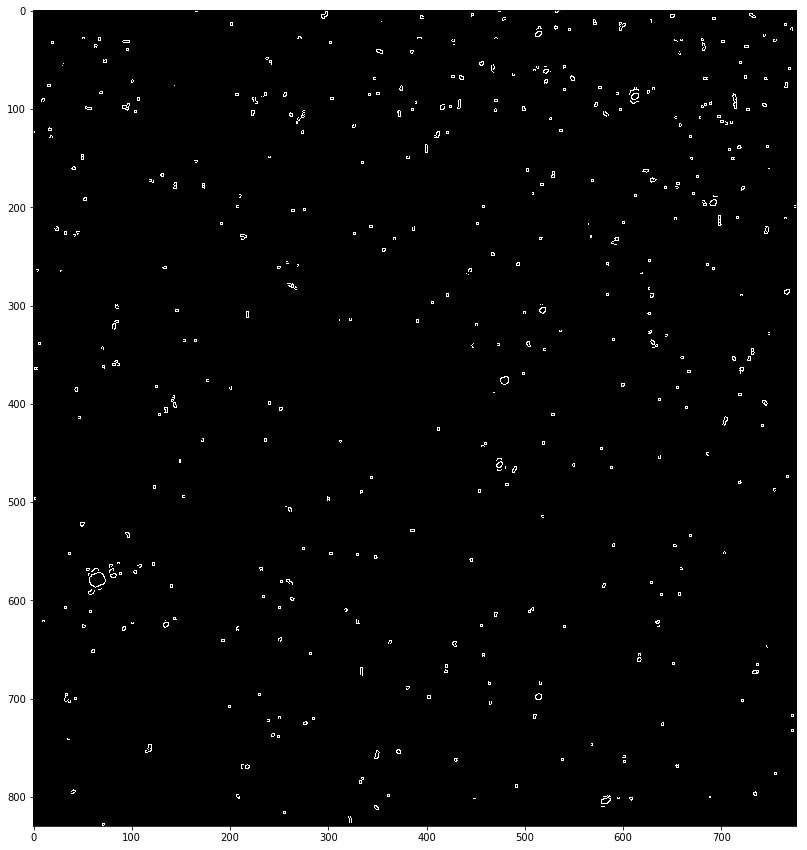

In [187]:
result = EdgeDetection_canny(pic1) 
plt.imshow(result, cmap=plt.cm.gray)

Number of keypoints Detected:  468


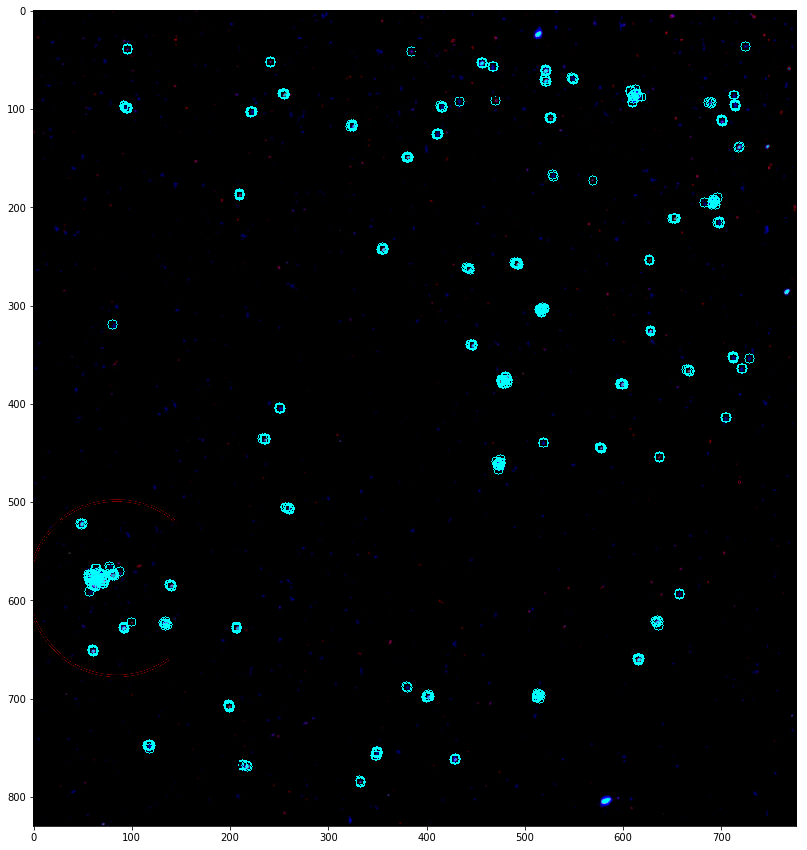

In [226]:
#orb detection 
result, arr = orb_detection(pic1) 
plt.imshow(result,cmap=plt.cm.gray)

Number of keypoints Detected:  5628


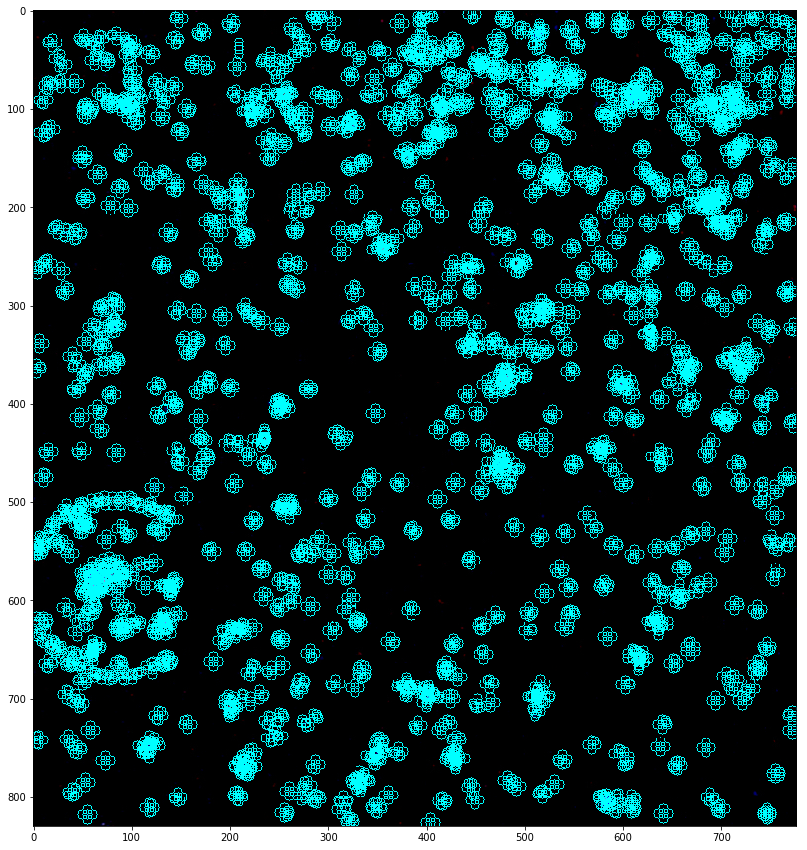

In [237]:
#fast detection 
result = fast_detection(pic1) 
plt.imshow(result)

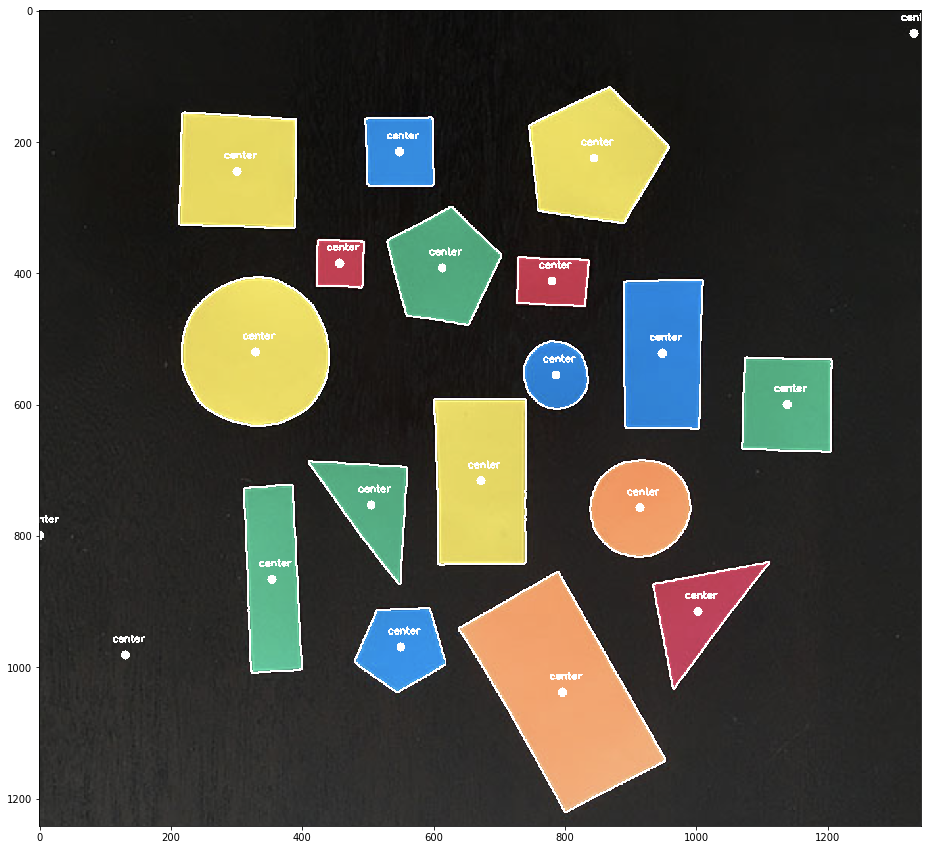

In [274]:
pic3 = mpimg.imread('/Users/jeffhe/Desktop/commitments/bliss/Solar-sail-localization/picbase/test.jpg')
result = countourCenter(pic3,MIN_THRESH = 1)
plt.imshow(result)

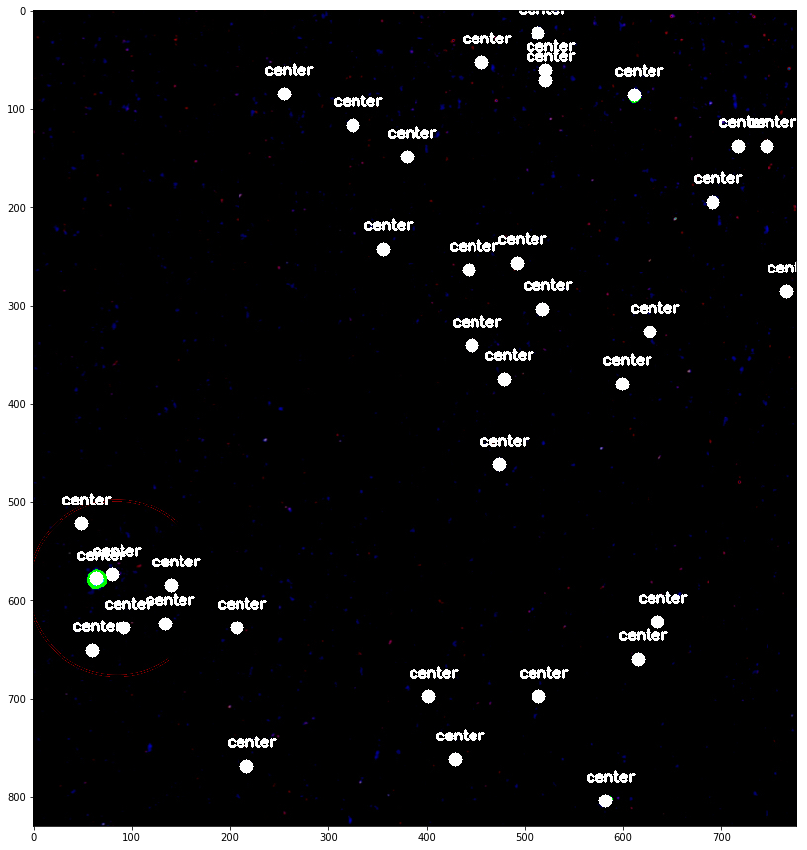

In [316]:
result, coor = countourCenter(pic1,MIN_THRESH = 1)
plt.imshow(result)

In [318]:
#print out the coordinates 
print(coor)

[[582, 804], [217, 769], [429, 762], [402, 698], [514, 698], [615, 660], [60, 651], [207, 628], [92, 628], [134, 624], [635, 622], [140, 585], [80, 574], [64, 578], [49, 522], [474, 462], [599, 380], [479, 375], [446, 341], [627, 327], [518, 304], [766, 286], [443, 264], [492, 257], [356, 243], [691, 195], [380, 149], [746, 138], [717, 138], [325, 117], [255, 85], [611, 86], [521, 71], [521, 61], [456, 53], [513, 23]]
